In [60]:
import pystac
from pystac_client import Client
from shapely.geometry import Point
import rioxarray
from pyproj import CRS
import geopandas as gpd
from folium import Map, TileLayer
import numpy as np
import xarray
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import dask
import rasterio
from rasterio.plot import show
import json
from datetime import datetime
import pandas as pd
import httpx
from shapely.geometry import Polygon, mapping
import pycountry
from skimage.filters import threshold_otsu

In [2]:
# Define url and initialize pystac client for fetching data
api_url = "https://earth-search.aws.element84.com/v0"
client = Client.open(api_url)

In [3]:
# Use L2A as it is same as L1C with processing done to remove atmospheric effects
# See: https://forum.step.esa.int/t/clarification-on-difference-between-l1c-and-l2a-data/24940 
collection = "sentinel-s2-l2a-cogs"  # Sentinel-2, Level 2A, COGs

In [4]:
# Get current date, and date within date offset for querying satellite data
current_time = datetime.now()
date_end = current_time.strftime("%Y-%m-%d")
date_offset = pd.Timedelta(days=2) # Set days to 1 to avoid duplicates (for now?)
date_start = (current_time - date_offset).strftime("%Y-%m-%d")
print(date_start, date_end)

2023-02-26 2023-02-28


In [5]:
# Get country bounding box
with open("../app/countries.json", "r") as f:
    country_bounds = json.load(f)

def get_country_bbox(country: str) -> dict[float, float, float, float]:
    # Search for country by name
    common_name_data = pycountry.countries.get(common_name=country)
    name_data = pycountry.countries.get(name=country)

    # Check that country name search returned valid item                                    
    if(not common_name_data and not name_data):
        raise AttributeError("Invalid country name")
    elif(None in [common_name_data, name_data]):
        country_data = common_name_data or name_data
    else:
        country_data = common_name_data

    # Get country code
    #print(country_data)
    country_code = country_data.alpha_2.lower()
    # Extract boundary bvox
    bbox = country_bounds.get(country_code).get("boundingBox")
    left = bbox.get("sw").get("lon")
    bottom = bbox.get("sw").get("lat")
    right = bbox.get("ne").get("lon")
    top = bbox.get("ne").get("lat")
    return [left, bottom, right, top]
    
country_bbox = get_country_bbox("american SamOA")
#type(country_bbox[0])
country_bbox

[-171.2951296, -14.7608358, -167.9322899, -10.8449746]

In [6]:
# Get country bounding box from https://gist.github.com/graydon/11198540
#'Bolivia', 
# Search for matching data within bounding box
#country_bbox = (-69.5904237535, -22.8729187965, -57.4983711412, -9.76198780685)
search = client.search(
    collections=[collection],
    bbox=country_bbox,
    max_items=500,
    datetime= f"{date_start}/{date_end}",
    query={"eo:cloud_cover":{"lt":10}, "sentinel:valid_cloud_cover": {"eq": True}}, # Select items with lower cloud cover
)

In [7]:
# Get items from query
items = search.get_all_items()
search.matched()

4

In [8]:
grid_cells = list()   
for i in items:
    print(f'{i}, Date: {i.datetime}, Grid cell: {i.properties.get("sentinel:utm_zone")} {i.properties.get("sentinel:grid_square")}')
    grid_cells.append(str(i.properties.get("sentinel:utm_zone")) + i.properties.get("sentinel:grid_square"))

<Item id=S2A_2LQJ_20230227_0_L2A>, Date: 2023-02-27 21:29:47+00:00, Grid cell: 2 QJ
<Item id=S2A_2LRJ_20230227_0_L2A>, Date: 2023-02-27 21:29:45+00:00, Grid cell: 2 RJ
<Item id=S2A_2LQK_20230227_0_L2A>, Date: 2023-02-27 21:29:40+00:00, Grid cell: 2 QK
<Item id=S2A_2LRK_20230227_0_L2A>, Date: 2023-02-27 21:29:39+00:00, Grid cell: 2 RK


In [40]:
# Check duplicates
#import collections
#collections.Counter(grid_cells).values()

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [93]:
from rio_tiler.io import COGReader
from cogeo_mosaic.mosaic import MosaicJSON
from cogeo_mosaic.backends import MosaicBackend

urls = [item.assets["B03"].href for item in items]
#urls = [item.self_href for item in items]
urls = urls[:2]
urls

['https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/2/L/MJ/2023/2/S2B_2LMJ_20230225_0_L2A/B03.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/2/L/NJ/2023/2/S2B_2LNJ_20230225_0_L2A/B03.tif']

In [9]:
#items[0].assets["B03"].href
#items[0].assets["B11"].href


In [10]:
items[0].bbox

[-168.65178856189547,
 -15.1700621933571,
 -168.117486492895,
 -14.454757819240648]

In [11]:
#mosaic_data = MosaicJSON.from_urls(urls = urls)
#with MosaicBackend("../app/data/test_mosaic.json", mosaic_def=mosaic_data) as mosaic:
#    mosaic.write(overwrite=True)
#    print(mosaic.info())

In [63]:
from threading import Lock

def match_projections(assets: dict[pystac.asset.Asset]) -> dict[xarray.core.dataarray.DataArray]:
    '''
    Desc: Match projections for two raster bands as needed.
    Example: bands = match_projections(test_assets)
    '''
    # Extract bands of interest with the use of Dask chunked arrays
    #green_band = rioxarray.open_rasterio(assets["B03"].href, lock=False, chunks = "auto")
    green_band = rioxarray.open_rasterio(assets["B03"].href).astype("float32")
    swir_band = rioxarray.open_rasterio(assets["B12"].href).astype("float32")
    
    # Reproject data to match shapes if unequal
    if(green_band.shape != swir_band.shape):
        print("Reprojecting...")

        if(green_band.shape > swir_band.shape):
            # Use tiled=True to write as chunked GeoTIFF,
            # use Lock() to synchronize threads
            # use compute=False for lazy execution
            #green_band = green_band.rio.reproject_match(swir_band, tiled=True, lock=Lock(), compute=False)
            green_band = green_band.rio.reproject_match(swir_band)

        else:
            swir_band = swir_band.rio.reproject_match(green_band)

    return {"green_band": green_band, "swir_band": swir_band}

def calc_mndwi(bands: dict[xarray.core.dataarray.DataArray]) -> xarray.core.dataarray.DataArray:
    '''
    Desc: Calculate Modified Normalized Difference Water Index (MNDWI) for detecting water
    Example: mndwi = calc_mndwi(bands)
    '''
    green_band = bands.get("green_band")
    swir_band = bands.get("swir_band")

    # Calculate the Modified Normalized Difference Water Index (MNDWI) for detecting water
    mndwi = (green_band - swir_band) / (green_band + swir_band)
    return mndwi

In [64]:
test_assets = items[0].assets
bands = match_projections(test_assets)
#test_assets

Reprojecting...


In [65]:
#mndwi_test = calc_mndwi(bands)
#mndwi_test.plot()
#type(mndwi_test)
green_band = bands.get("green_band")
swir_band = bands.get("swir_band")

In [54]:
# We will use the Modified Normalized Difference Water Index (MNDWI) for detecting water
# https://www.space4water.org/taxonomy/term/1246#:~:text=%22The%20Modified%20Normalized%20Difference%20Water,open%20water%20in%20other%20indices.
# "MNDWI = (Green - SWIR) / (Green + SWIR)
# Green = pixel values from the green band
# SWIR = pixel values from the short-wave infrared band"
# First get green and SWIR bands
#green_band = rioxarray.open_rasterio(test_assets["B03"].href)
#swir_band = rioxarray.open_rasterio(test_assets["B12"].href)

In [66]:
# Check extents and projections
print(green_band.shape)
print(swir_band.shape)
print(green_band.rio.crs)
print(swir_band.rio.crs)
print(swir_band[0,0,0])

print(green_band.shape == swir_band.shape)

(1, 5490, 5490)
(1, 5490, 5490)
EPSG:32702
EPSG:32702
<xarray.DataArray ()>
array(0., dtype=float32)
Coordinates:
    band         int64 1
    x            float64 7e+05
    y            float64 8.4e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0
True


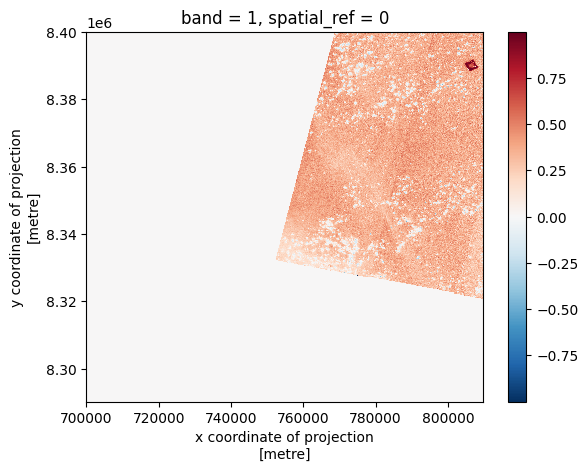

In [67]:
# Calculate Modified Normalized Water Difference Index
# Note: Use 0 to fill nodata areas with 0
#print(green_band.min(), green_band.max(), swir_band.min(), swir_band.max())
#mndwi_arr = np.where(img.mask, (green_band - swir_band) / (green_band + swir_band), 0)
numerator = (green_band - swir_band)
denominator = (green_band + swir_band)
mndwi_arr = np.divide(numerator, denominator, np.zeros_like(numerator), where=denominator!=0)
#np.unique(swir_band)
#mndwi_arr = (green_band - swir_band) / (green_band + swir_band)
mndwi_arr.plot()

otsu: 0.16859284
<xarray.DataArray ()>
array(False)
Coordinates:
    spatial_ref  int64 0 <xarray.DataArray ()>
array(True)
Coordinates:
    spatial_ref  int64 0


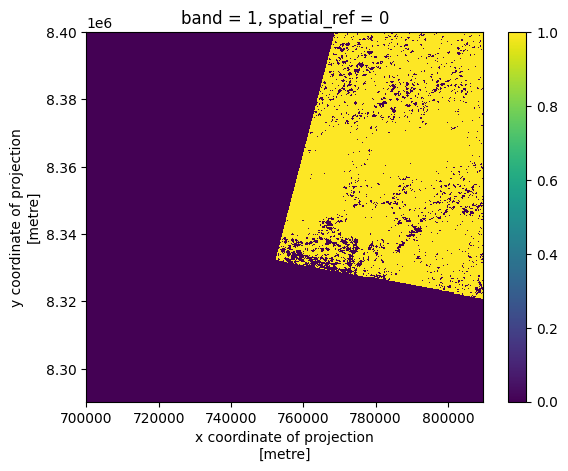

In [84]:
# Classify output
#classified_arr = xarray.apply_ufunc(
#    np.digitize,
#    mndwi_arr,
#    self.class_bins,
#    dask="allowed")


# Apply Otsu Thresholding method
otsu_threshold = threshold_otsu(mndwi_arr.values)
print("otsu:", otsu_threshold)

# Use threshold to classify data
#classified_arr = mndwi_arr >= otsu_threshold
#classified_arr = np.where(mndwi_arr >= otsu_threshold, 1, 0)
classified_arr = (mndwi_arr >= otsu_threshold)
print(classified_arr.min(), classified_arr.max())
#print(np.quantile(classified_arr, q=(0,0.25,0.5,0.75,1)))
#type(classified_arr)
classified_arr.plot()
#mndwi_arr *= (255.0/mndwi_arr.max())
#print(np.quantile(mndwi_arr, q=(0,0.25,0.5,0.75,1)))


#classified_arr = np.digitize(x=mndwi_arr, bins=self.class_bins)

# ImageData only accept image in form of (count, height, width)
#classified_arr = np.expand_dims(classified_arr, axis=0).astype(self.output_dtype)
#classified_arr = np.expand_dims(classified_arr, axis=0)
#classified_arr = np.around(classified_arr).astype(int)
#print(classified_arr.min(), classified_arr.max())
#print(classified_arr)


In [ ]:
# Plot MNDWI
# Note: use robust=True, otherwise outliers color the picture
#mndwi.plot(robust=True)

In [ ]:
# Plot histogram of selected values - less outliers
#mndwi.plot.hist(bins=(0, 0.2, 0.4, 0.6, 0.8, 1))
mndwi.plot.hist(bins=(0,5,10,15,20,25,30))

In [ ]:
# Interpolate missing values
#mndwi_nonan = mndwi.interpolate_na(dim="x")

In [ ]:
#mndwi_nonan.plot.hist()

In [ ]:
# Classify flooded and non-flooded data
# Use 'expert-defined threshold' of 0.3 
# See: https://openaccess.thecvf.com/content_CVPRW_2020/papers/w11/Bonafilia_Sen1Floods11_A_Georeferenced_Dataset_to_Train_and_Test_Deep_Learning_CVPRW_2020_paper.pdf
#class_bins = (0.0, 15)
#mndwi_classified = xarray.apply_ufunc(
#    np.digitize,
#    mndwi,
#    class_bins,
#)
from typing import Union

def classify_raster(class_bins: Union[list[float], tuple[float]], raster) -> xarray.core.dataarray.DataArray:
    
    classified = xarray.apply_ufunc(
        np.digitize,
        raster,
        class_bins,
        dask="allowed")
    
    # Write to disk
    filename = "mndwi_" + datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
    filepath = "./" + filename + ".tif"
    classified.rio.to_raster(filepath)

    return classified, filename, filepath

bins = [0.0, 15.0]
mndwi_test_class, filename, filepath = classify_raster(bins, mndwi_test)
type(mndwi_test_class)
print(filepath)

In [ ]:
# Save to file
filename = "mndwi_" + datetime.now().strftime("%Y-%m-%d")
mndwi_test_class.rio.to_raster("./" + filename + ".tif")

In [ ]:
mndwi_test_class.plot.hist()

In [ ]:
mndwi_classified.plot(robust=True)

In [ ]:
visual = rioxarray.open_rasterio(test_assets["visual"].href)

In [ ]:
visual = visual.load()
visual.plot.imshow(robust=True)

In [ ]:
scl = rioxarray.open_rasterio(test_assets["SCL"].href)
scl = scl.load()
scl.plot.hist()

In [ ]:
scl.squeeze().plot.imshow(levels=range(15), figsize=(12,10))

In [ ]:
titiler_endpoint = "http://127.0.0.1:8000"
#url = "https://opendata.digitalglobe.com/events/mauritius-oil-spill/post-event/2020-08-12/105001001F1B5B00/105001001F1B5B00.tif"

#titiler_endpoint = "https://titiler.xyz"  # Developmentseed Demo endpoint. Please be kind.
url = "https://opendata.digitalglobe.com/events/mauritius-oil-spill/post-event/2020-08-12/105001001F1B5B00/105001001F1B5B00.tif"
#item = httpx.get(cog_item).json()
#print(item)
#for it, asset in item["assets"].items():
#    print("Name:", it, "| Format:", asset["type"])

In [ ]:
# Fetch File Metadata to get min/max rescaling values (because the file is stored as float32)
r = httpx.get(
    #f"{titiler_endpoint}/cog/info",
    f"{titiler_endpoint}/info",
    params = {
        "url": url,
    }
).json()
print(r)

#bounds = r["bounds"]
#print(r)

In [ ]:
stac_item = "https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_30TVT_20221112_0_L2A"
item = httpx.get(stac_item).json()
#print(item)
for it, asset in item["assets"].items():
    print("Name:", it, "| Format:", asset["type"])

In [ ]:
#mndwi_classified.rio.to_raster("test.tif")
#catalog = pystac.Catalog(id='flood-data-catalog', description='Flood data catalog.')
#print(pystac.Item.__doc__)
import os

def create_stac_catalog():
    if(os.path.exists("stac")):
        print("exists")
        catalog = pystac.read_file("./stac/catalog.json")
        return catalog
    else:
        catalog = pystac.Catalog(id='flood-data-catalog', description='Flood data catalog.')
        return catalog


create_stac_catalog()

In [ ]:
type(mndwi_test_class)

In [ ]:

def get_bbox_and_footprint(raster: xarray.core.dataarray.DataArray) -> tuple[list, mapping]:
    ''' 
    Desc: Extract bounding box coordinates from raster.clear
    Example: bbox, footprint = get_bbox_and_footprint(your_raster)
    '''
    bounds = raster.rio.bounds()
    bbox = [bounds[0], bounds[1], bounds[2], bounds[3]]
    footprint = Polygon([
        [bounds[0], bounds[1]],
        [bounds[0], bounds[3]],
        [bounds[2], bounds[3]],
        [bounds[2], bounds[1]]
    ])

    return (bbox, mapping(footprint))
    
bbox, footprint = get_bbox_and_footprint(mndwi_test_class)
    
item = pystac.Item(id=filename + "2",
                 geometry=footprint,
                 bbox=bbox,
                 datetime=datetime.utcnow(),
                 properties={})

item

In [ ]:
#assert item.get_parent() is None
catalog.add_item(item)
item.get_parent()
catalog.describe()

In [ ]:
item.add_asset(
    key='image',
    asset=pystac.Asset(
        href=filepath, # TODO: get as in memory object?
        media_type=pystac.MediaType.GEOTIFF
    )
)

In [ ]:
print(json.dumps(item.to_dict(), indent=4))

In [ ]:
#print(catalog.get_self_href() is None)
catalog.normalize_hrefs('./stac')
catalog.get_self_href()

In [ ]:
catalog.save(catalog_type=pystac.CatalogType.SELF_CONTAINED)

In [ ]:
item.get_parent()

In [ ]:
#with open(catalog.self_href) as f:
#    print(f.read())

with open(item.self_href) as f:
    print(f.read())

In [ ]:
# Get Tile URL
r = httpx.get(
    f"{titiler_endpoint}/info",
    params = (
        ("url", stac_item),
        #("url", "file:///Users/sashkawarner/repos/flood-data-api/scripts/stac/"),
        # Get info for multiple assets
        #("assets","blue"), ("assets","green"),
        ("assets","blue")
    )
).json()
print(r)

In [ ]:
r = httpx.get(
    f"{titiler_endpoint}/tilejson.json",
    params = {
        "url": stac_item,
        "assets": "visual",
        "minzoom": 8,  # By default titiler will use 0
        "maxzoom": 14, # By default titiler will use 24
    }
).json()
print(r)
#bounds = r["bounds"]

In [ ]:
r = httpx.get(
    f"{titiler_endpoint}/tilejson.json",
    params = {
        "url": "../scripts/stac/local-image/local-image.json",
        "assets": "image",
        "minzoom": 8,  # By default titiler will use 0
        "maxzoom": 14, # By default titiler will use 24
    }
).json()
print(r)
#bounds = r["bounds"]

In [ ]:
# Enter in Z for Zoom, X and Y for tile grid cell
#'http://127.0.0.1:8000/tiles/WebMercatorQuad/10/501/358?url=https%3A%2F%2Fearth-search.aws.element84.com%2Fv1%2Fcollections%2Fsentinel-2-l2a%2Fitems%2FS2A_30TVT_20221112_0_L2A&assets=visual'
#http://127.0.0.1:8000/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?url=..%2Fscripts%2Fstac%2Flocal-image%2Flocal-image.json&assets=image

In [ ]:
r = httpx.get(
    f"{titiler_endpoint}/preview",
    params = {
        "url": "../scripts/stac/local-image/local-image.json",
        "assets": "image",
        "minzoom": 8,  # By default titiler will use 0
        "maxzoom": 14, # By default titiler will use 24
    }
).json()
print(r)
#bounds = r["bounds"]

In [ ]:
m = Map(
    location=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom_start=10
)

tiles = TileLayer(
    tiles=r["tiles"][0],
    min_zoom=r["minzoom"],
    max_zoom=r["maxzoom"],
    opacity=1,
    attr="ESA"
)
tiles.add_to(m)
m

In [ ]:
r = rasterio.open("../scripts/test.tif")

In [ ]:
type(r)
#r.rio.bounds()

In [ ]:
#array = r.read()
#array
show(r,1)

In [ ]:
bounds = [[r.bounds.bottom, r.bounds.left], [r.bounds.top, r.bounds.right]]
overlay = folium.raster_layers.ImageOverlay(r.read(1), bounds)
overlay.add_to(m)

In [ ]:
m